In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
staticfile = "/home/glemieux/Data/luh2/staticData_quarterdeg.nc"
surfdatfile = '/home/glemieux/Data/surfdat/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc'
clmsurffile = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_surf_deg025.nc'
forestfile = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhforest_deg025.nc'
otherfile = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhother_deg025.nc'
pasturefile = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhpasture_deg025.nc'

In [3]:
ds_static = xr.open_dataset(staticfile)
ds_surf = xr.open_dataset(surfdatfile)
ds_clmsurf = xr.open_dataset(clmsurffile)
ds_forest = xr.open_dataset(forestfile)
ds_other = xr.open_dataset(otherfile)
ds_pasture = xr.open_dataset(pasturefile)

# Questions
1. Does the mask need to be T/F or 0/1 for xesmf regridding?
2. Do the mask Lat/Lon need to be aligned (i.e. both 0 -> 360) or can xesmf convert on the fly?
3. Should the clmsurfdat use the static icwtr mask or should it use it's own PCT_NATVEG (like the target regrid file)?

# Answers

### 1. It seems like we need to mask to avoid including NaNs:

> By default, xESMF treats NaNs like regular values hence potentially resulting in missing values bleeding into the regridded field and creating insconsistencies in the resulting masked array.

xESMF examples use `1/0` values where the `NaN` are to mask

> `ds["mask"] = xr.where(~np.isnan(ds["zeta"].isel(ocean_time=0)), 1, 0)`

The `Regridder` reference states that it wants 1, 0 explicitly.  That said, does as T/F mask convert automatically?

> All variables that the cf-xarray accessor understand are accepted. Otherwise, look for lon, lat, optionally lon_b, lat_b for conservative methods, and mask. **Note that for mask, the ESMF convention is used, where masked values are identified by 0, and non-masked values by 1.** (emphasis mine)

Also of note; providing bounds is ideal for conservative regridding:
> For conservative methods, if bounds are not present, they will be computed using cf-xarray (only 1D coordinates are currently supported).

# Surface dataset PCT_NATVEG as mask

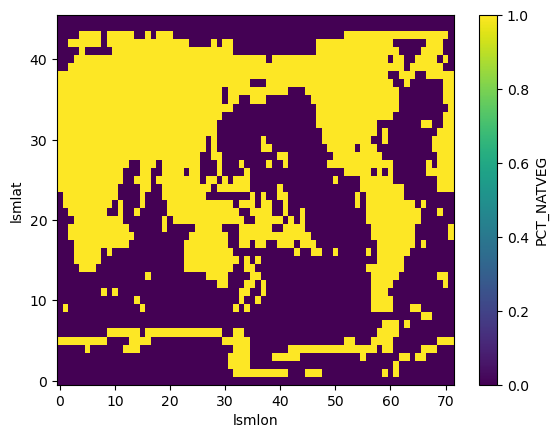

In [4]:
mask_surf = ds_surf.PCT_NATVEG > 0
mask_surf.plot()

Note that the lat/lon dimensions/coordinates are names `lsmlat/lsmlon` and need conversion before comparison or regridding

# Ice water as mask

In [5]:
icwtr = ds_static.icwtr.astype('float64')
mask_static_ratio = (1-icwtr) / (1-icwtr)
mask_static_not = (icwtr != 1)

Text(0.5, 1.0, 'Mask as not 1.0')

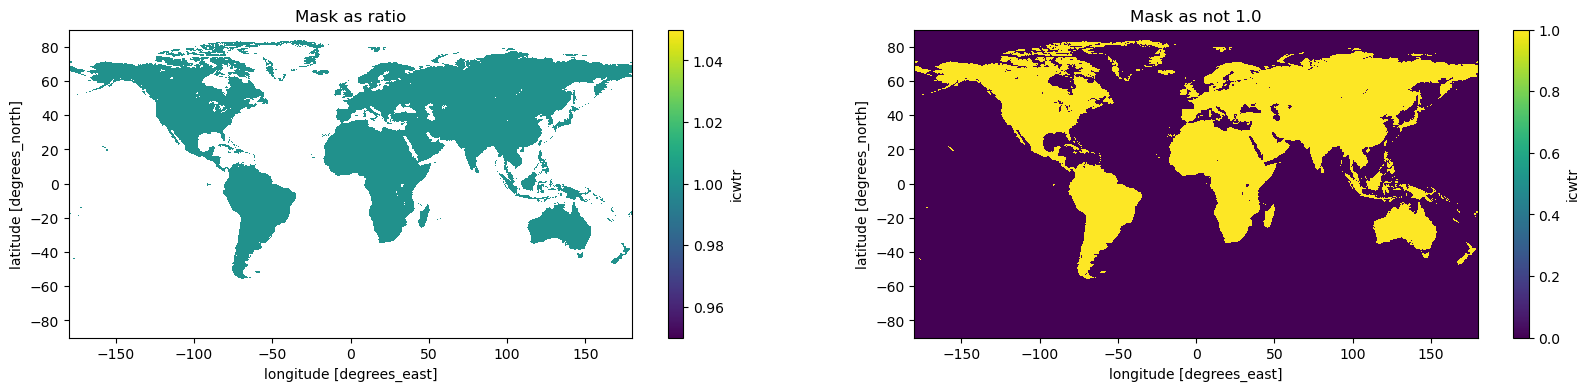

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
mask_static_ratio.plot(ax=ax1)
ax1.set_title('Mask as ratio')
mask_static_not.plot(ax=ax2)
ax2.set_title('Mask as not 1.0')

### Does the mask contain `NaN`?

In [7]:
print("icwtr != 1 nans:", mask_static_not.isnull().any().data)
print("ratio method nans:", mask_static_ratio.isnull().any().data)

icwtr != 1 nans: False
ratio method nans: True


### We can use the `where` function to make sure we get 1/0
Assuming that `T/F` doesn't automatically work for xesmf.  *Note that I think T/F* is technically ok, although I haven't found documentation referencing this.*

In [8]:
mask_static_not_01 = xr.where(mask_static_not,1,0)
mask_static_ratio_01 = xr.where(mask_static_ratio == 1.,1,0)
diff_mask_static_01 = mask_static_not_01 - mask_static_ratio_01
diff_mask_static_01.sum().data

array(0)

Since the sum of the mask is zero, the two are equivalent.  

# CLM5 surface data quarter degree `PCT_NATVEG` as mask

Note: only the CLM5 current surface data set includes `PCT_NATVEG`

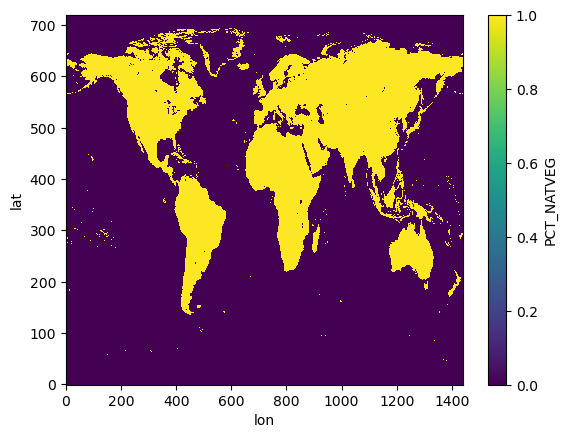

In [9]:
mask_clmsurf = ds_clmsurf.PCT_NATVEG > 0
mask_clmsurf.plot()

# CLM5 Forest `LANDMASK` as landmask

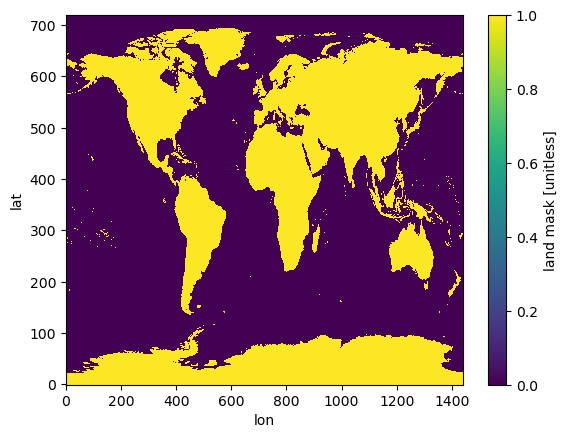

In [10]:
ds_forest.LANDMASK.plot()

In [11]:
# Note that the landmask is just the landfrac greater than zero
((ds_forest.LANDFRAC > 0) == ds_forest.LANDMASK).all()

<xarray.DataArray ()>
array(True)

# Comparing masks

## CLM5 LANDMASKS comparisons for each landuse dataset

In [12]:
diff_forest_clmsurf = ds_forest.LANDMASK - ds_clmsurf.LANDMASK
diff_clmsurf_pasture = ds_clmsurf.LANDMASK - ds_pasture.LANDMASK
diff_pasture_other = ds_pasture.LANDMASK - ds_other.LANDMASK
print("Sum of Forest - Current surface landmask differences:", diff_forest_clmsurf.sum().data)
print("Sum of Current surface - Pasture landmask differences:", diff_clmsurf_pasture.sum().data)
print("Sum of Pasture - Other surface landmask differences:", diff_pasture_other.sum().data)

Sum of Forest - Current surface landmask differences: 0.0
Sum of Current surface - Pasture landmask differences: 0.0
Sum of Pasture - Other surface landmask differences: 0.0


**Conclusion:** the CLM5 `LANDMASK` values are all the same.

## Comparing Static water data, landmask, and pct_natveg

Remember to convert the current surface and static masks to `1/0`

In [13]:
# Diff landmask and current surf mask
diff_landmask_pctmask = ds_forest.LANDMASK - xr.where(mask_clmsurf,1,0)

# Convert the current surf data for comparison first
mask_clmsurf_copy = mask_clmsurf.copy(deep=True)
mask_clmsurf_copy["lon"] =  mask_clmsurf.lon * 0.25 - 180. + 1./8.
mask_clmsurf_copy["lat"] =  mask_clmsurf.lat * 0.25 - 90. + 1./8.

# Diff current surf mask and static icwtr mask, use logical xor to compare where T/F don't match
# diff_pctmask_staticmask = xr.where(mask_clmsurf_copy,1,0) - xr.where(mask_static_not,1,0)
diff_pctmask_staticmask = np.logical_xor(mask_clmsurf_copy, mask_static_not)

Text(0.5, 1.0, 'PCT_NATVEG - Static icwtr')

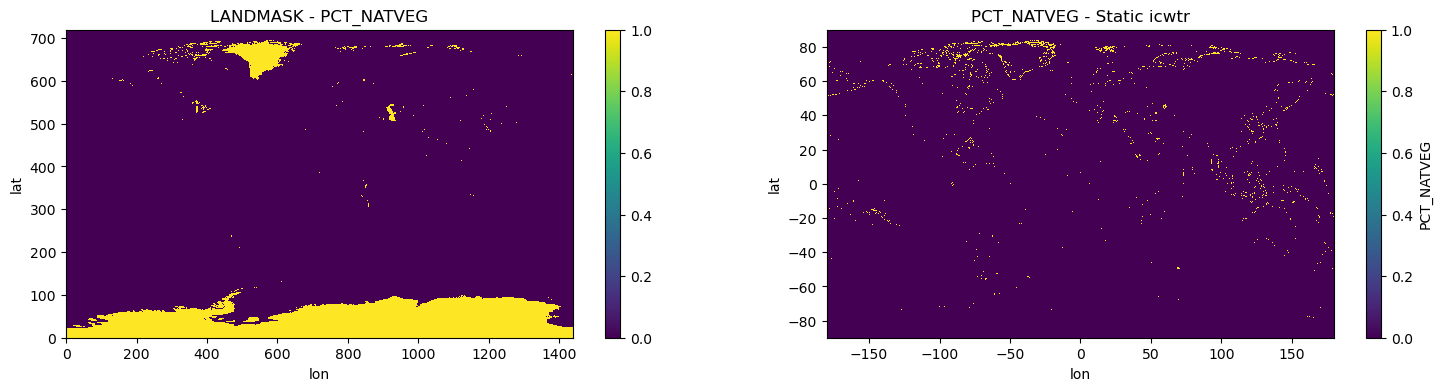

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))
diff_landmask_pctmask.plot(ax=ax1)
ax1.set_title('LANDMASK - PCT_NATVEG')
diff_pctmask_staticmask.plot(ax=ax2)
ax2.set_title('PCT_NATVEG - Static icwtr')

In [15]:
print("diff_landmask_pctmask sum where not 1 is zero:", ((diff_landmask_pctmask.where(diff_landmask_pctmask != 1.0).sum()) == 0.).data)

diff_landmask_pctmask sum where not 1 is zero: True


The `LANDMASK` includes areas that we don't want to include as land, like Greenland, Antarctica and the Caspian Sea.  The `PCT_NATVEG` from the current surface data is more comprehensive than the static icwtr mask.  
**Conclusion:** Use the `PCT_NATVEG` inplace of the other two.

# Comparing the calculated fraction of bareground against masks

## Comparing the *non-bareground* percentage from each landuse dataset

In [49]:
percent = []
for i,ds in enumerate(ds_clmlist):
    percent.append(ds.PCT_NAT_PFT.isel(natpft=slice(1,None)).sum(dim='natpft'))

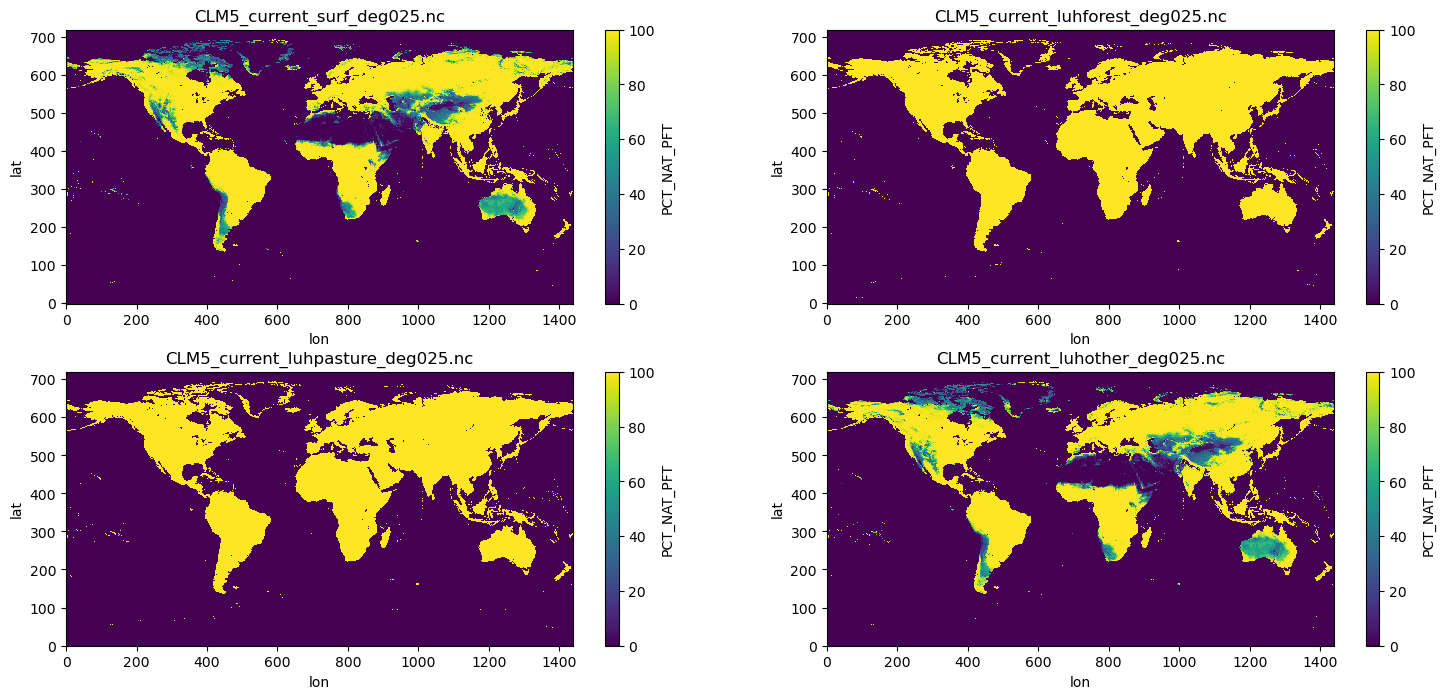

In [51]:
f, ax = plt.subplots(2, 2, figsize=(18, 8))
plt.subplots_adjust(hspace=0.25)
for i,ai in enumerate(ax.flat):
    percent[i].plot(ax=ai)
    ai.set_title(ds_clmlist[i].title)

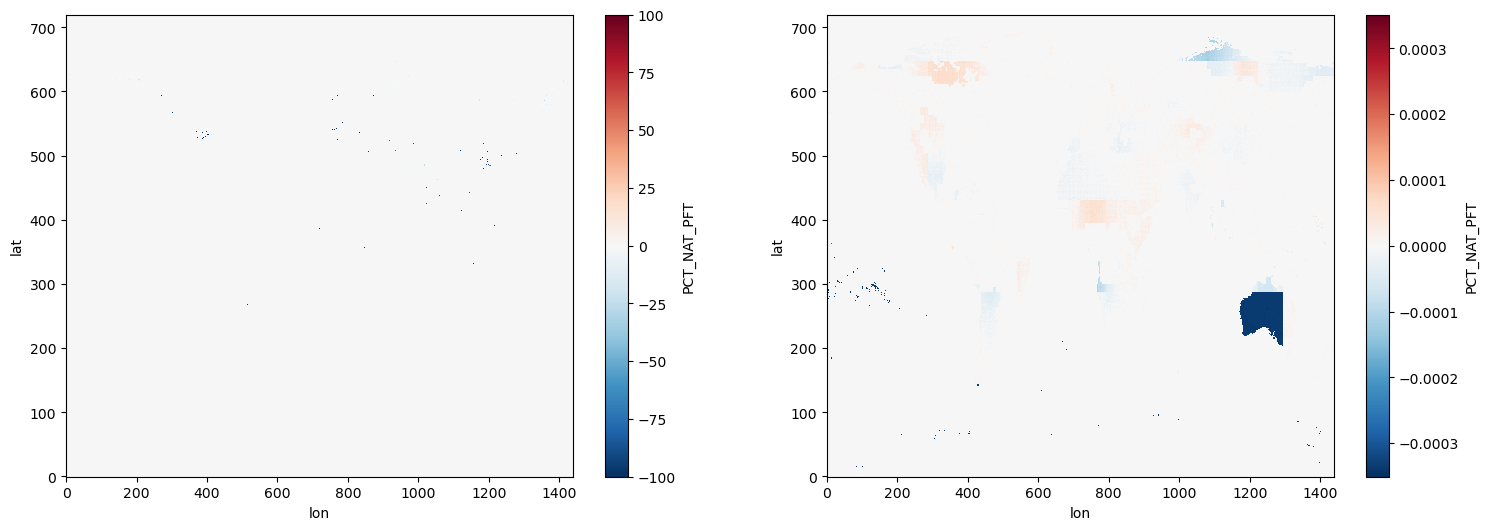

In [52]:
f,ax = plt.subplots(1,2,figsize=(18,6))
(percent[0] - percent[3]).plot(ax=ax[0])
(percent[1] - percent[2]).plot(ax=ax[1])

## Comparing the bareground percentage from each landuse dataset

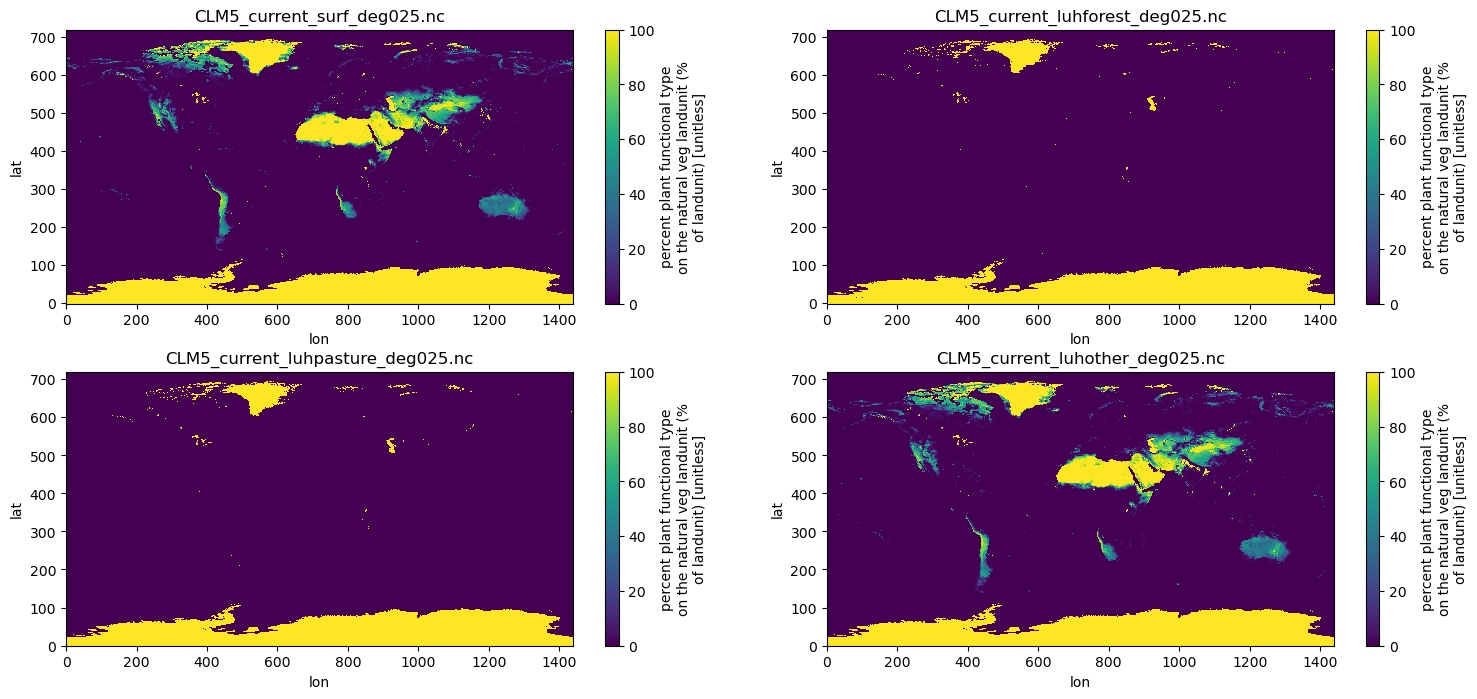

In [27]:
ds_clmlist = [ds_clmsurf, ds_forest, ds_pasture, ds_other]
f, ax = plt.subplots(2, 2, figsize=(18, 8))
plt.subplots_adjust(hspace=0.25)
for i,ai in enumerate(ax.flat):
    ds_clmlist[i].PCT_NAT_PFT.isel(natpft=0).plot(ax=ai)
    ai.set_title(ds_clmlist[i].title)

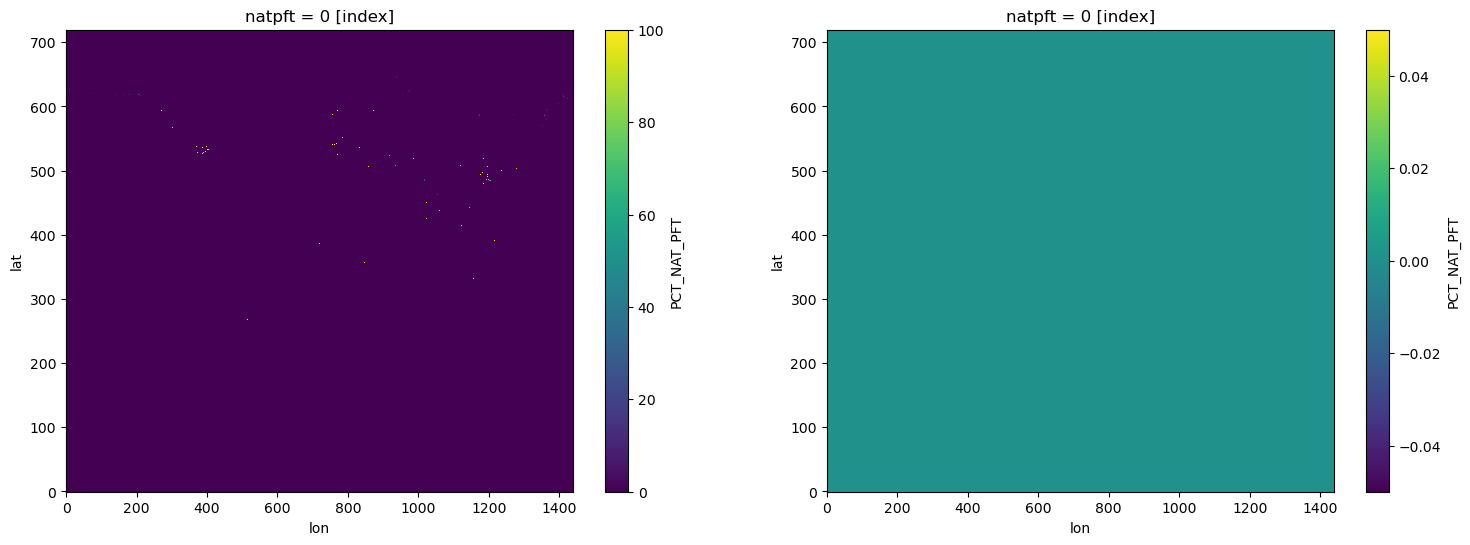

In [41]:
f,ax = plt.subplots(1,2,figsize=(18,6))
(ds_clmsurf.PCT_NAT_PFT.isel(natpft=0) - ds_other.PCT_NAT_PFT.isel(natpft=0)).plot(ax=ax[0])
(ds_forest.PCT_NAT_PFT.isel(natpft=0) - ds_pasture.PCT_NAT_PFT.isel(natpft=0)).plot(ax=ax[1])cv

The current surface bareground is *inclusive* of the 'other' bareground.  The pasture and the forest baregrounds match.

*Note:* The forest bareground data points are all 100%.

In [118]:
((ds_forest.PCT_NAT_PFT.isel(natpft=0) == 100.) == (ds_forest.PCT_NAT_PFT.isel(natpft=0) > 0.)).all()

<xarray.DataArray 'PCT_NAT_PFT' ()>
array(True)
Coordinates:
    natpft   int32 0

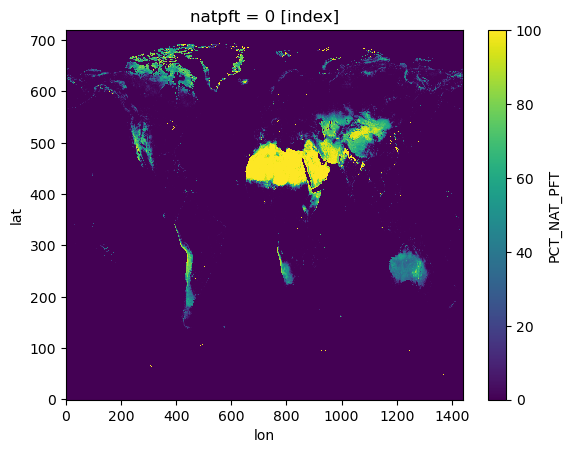

In [54]:
(ds_clmsurf.PCT_NAT_PFT.isel(natpft=0) - ds_forest.PCT_NAT_PFT.isel(natpft=0)).plot()

Since the values are all positive, the current surface bareground is *inclusive* of the forest/pasture bareground.

### Define mask where the current surface bareground is equal to 100

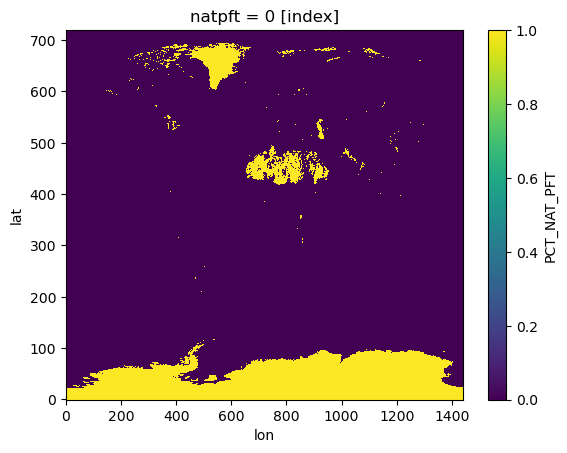

In [72]:
mask_bareground_100p = (ds_clmsurf.PCT_NAT_PFT.isel(natpft=0) == 100.)
mask_bareground_100p.plot()
# ds_clmsurf.PCT_NAT_PFT.isel(natpft=0).where(ds_clmsurf.PCT_NAT_PFT.isel(natpft=0) == 100.).plot()

Compare where the 100% surface bareground and the forest bareground do not match

Text(0.5, 0.98, 'Comparison of 100% bareground')

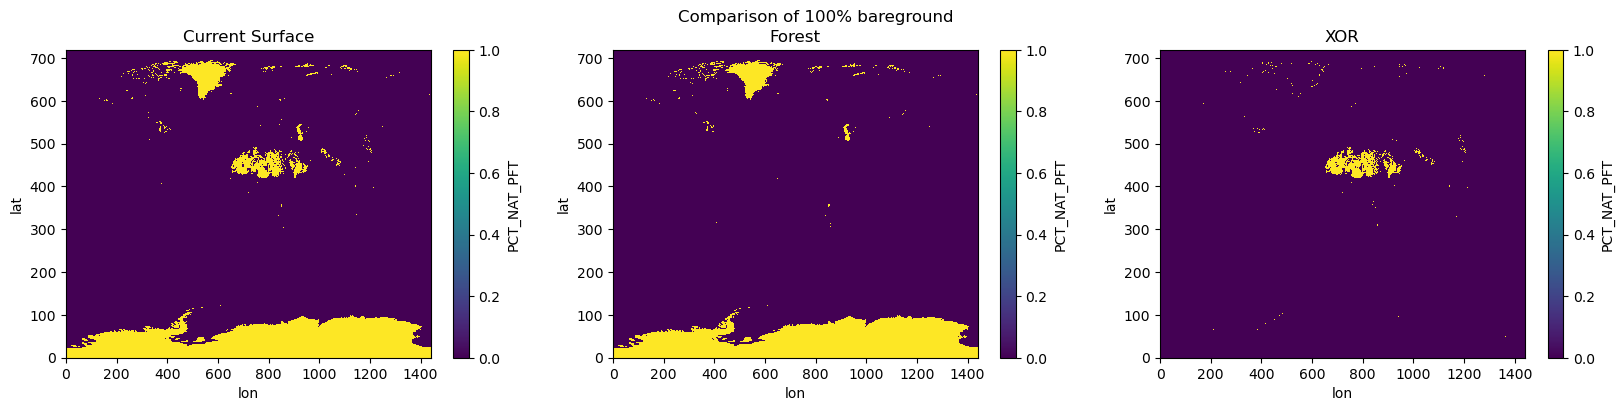

In [141]:
mask_forest_bareground = ds_forest.PCT_NAT_PFT.isel(natpft=0) > 0.
mask_xor_forest_clmsurfbareground = np.logical_xor(mask_bareground_100p,mask_forest_bareground)
f,ax = plt.subplots(1,3,figsize=(20,4))
mask_bareground_100p.plot(ax=ax[0])
ax[0].set_title("Current Surface")
mask_forest_bareground.plot(ax=ax[1])
ax[1].set_title("Forest")
mask_xor_forest_clmsurfbareground.plot(ax=ax[2])
ax[2].set_title("XOR")
f.suptitle("Comparison of 100% bareground")

Text(0.5, 1.0, 'Difference')

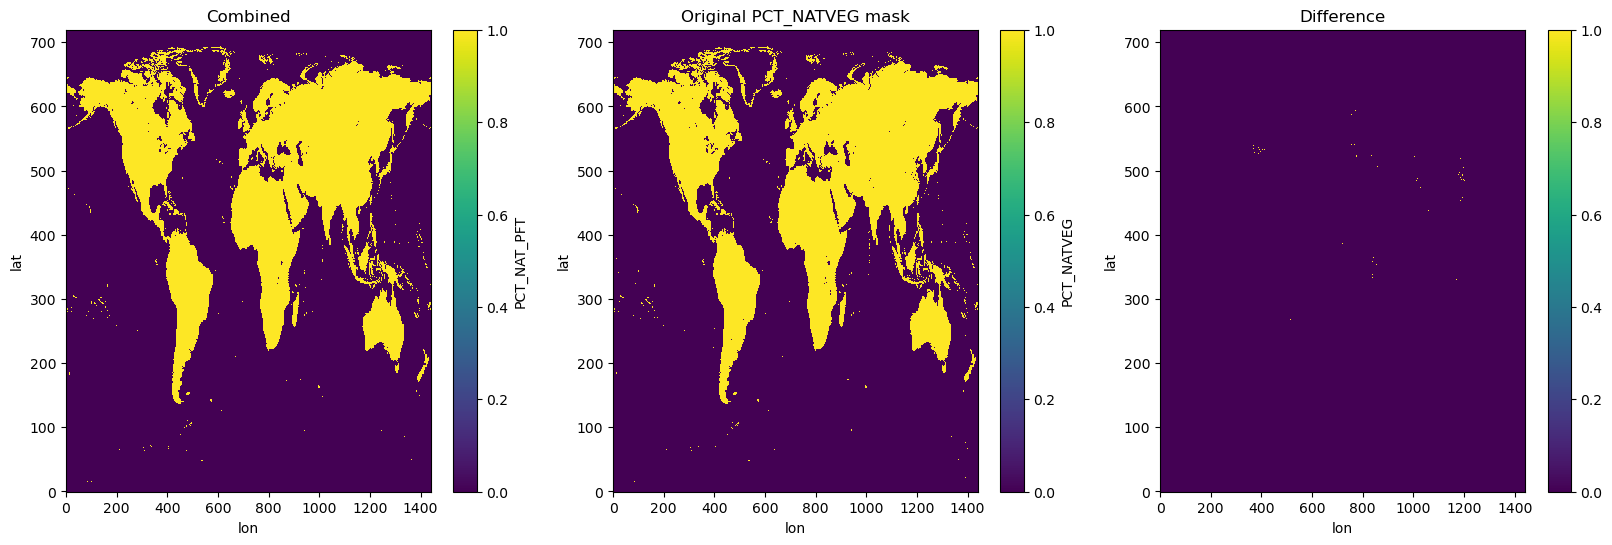

In [142]:
mask_clmsurf_xor = np.logical_or(mask_xor_forest_clmsurfbareground,mask_clmsurf)
# mask_clmsurf_xor.plot()
f,ax = plt.subplots(1,3,figsize=(20,6))
mask_clmsurf_xor.plot(ax=ax[0])
ax[0].set_title("Combined")
mask_clmsurf.plot(ax=ax[1])
ax[1].set_title("Original PCT_NATVEG mask")
(mask_clmsurf_xor ^ mask_clmsurf).plot(ax=ax[2])
ax[2].set_title("Difference")

## Extra: where is the static data fstnf masking?

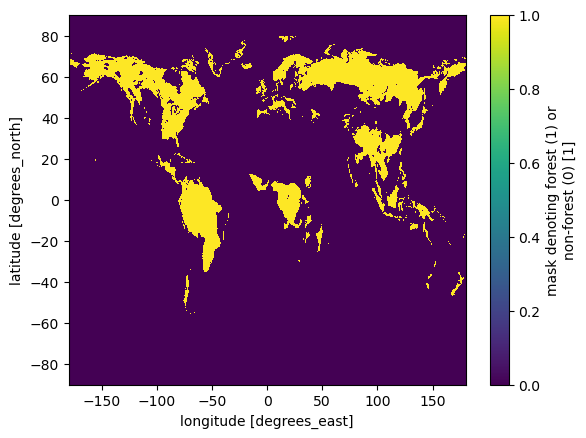

In [144]:
mask_fstnf = ds_static.fstnf
mask_fstnf.plot()

### Extra: Does joining the current surface `PCT_NATVEG` to the current surface 100% bareground mask result in an existing mask?

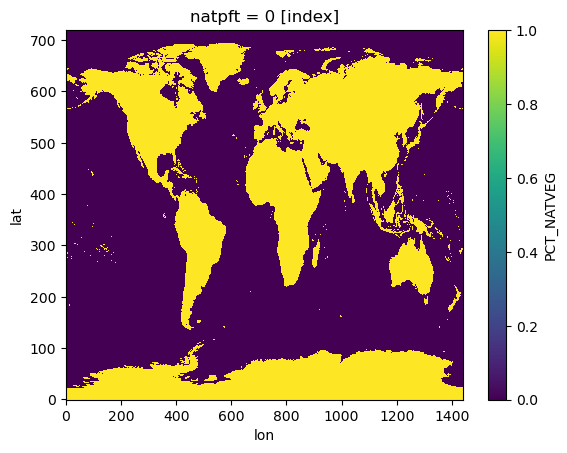

In [111]:
full_mask = np.logical_or(mask_clmsurf,mask_bareground_100p)
full_mask.plot()

### Compare this mask to the sum of all the natpfts for forest

In [114]:
mask_forest_all_natpft = ds_forest.PCT_NAT_PFT.sum(dim='natpft') > 0.
(full_mask == mask_forest_all_natpft).all()

<xarray.DataArray ()>
array(True)
Coordinates:
    natpft   int32 0

**Conclusion:** The computed 'full_mask' (current surface `pct_natveg` + current surface 100% bareground) is equivalent to the sum of the `pct_nat_pft` for the forest